In [1]:
import os
import json
from copy import deepcopy
from collections import Counter

import numpy as np
import pandas as pd
from natsort import natsorted

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from projects.data_cleaning import *

database_folder_path = '/media/kai/Shared Space/database-ICU/eICU/all'

# Group patient by admission diagnosis and demographics

In [ ]:
patient_selected = []
patient_demo_dict = {}
patients_grouped_by_diagnosis = {}
patients_grouped_by_age_and_gender = {'Male':{}, 'Female':{}}
patient_data = {}
for demo in DEMO_ITEMS:
    patient_demo_dict[demo] = []
    
for filename in os.listdir(database_folder_path):
    data = json.load(open(database_folder_path+filename))
    data = data['patient']
    dx = data['apacheadmissiondx'][0]
    age = data['age'][0]
    gender = data['gender'][0]
    if len(dx)>0 and len(age)>0 and len(gender)>0:
        if dx in DX_SELECTED:
            pid = data['patientunitstayid'][0]
            patient_selected.append(pid)
            add_list_elem_in_dict(patients_grouped_by_diagnosis, dx, pid)
            for gender_group in ['Male', 'Female']:
                if gender==gender_group:
                    if age == '> 89':
                        age_group = 9
                    elif age.isdigit():
                        age_group = int(age) // 10
                    add_list_elem_in_dict(patients_grouped_by_age_and_gender[gender_group], 
                                          AGE_RANGES[age_group], pid)
            for demo in DEMO_ITEMS:
                patient_demo_dict[demo].append(data[demo][0])

# print (f'patient number: {len(patient_selected)}')
np.save('processed/patient_grouped_by_diagnosis', patients_grouped_by_diagnosis)
np.save('processed/patients_grouped_by_age_and_gender', patients_grouped_by_age_and_gender)

In [5]:
with open('admission_diagnosis_count.txt', 'a') as file:
    for k in patients_grouped_by_diagnosis:
        file.write(f'{k};; {len(patients_grouped_by_diagnosis[k])}\n')

# Plot patient data distrubution for Dx: Infarction, acute myocardial (MI)

In [2]:
patients_grouped_by_diagnosis = np.load('processed/patient_grouped_by_diagnosis.npy', allow_pickle=True).item()
diagnosis = 'Infarction, acute myocardial (MI)'
patients_id = patients_grouped_by_diagnosis[diagnosis]

In [3]:
patient = {}
for pid in patients_id:
    data = load_patient_data_by_id(pid)
    patient[pid] = {}
    patient[pid]['age'] = data['patient']['age'][0]
    patient[pid]['gender'] = data['patient']['gender'][0]
    patient[pid]['unitdischargestatus'] = data['patient']['unitdischargestatus'][0]
    patient[pid]['unitlengthofstay'] = data['patient']['unitdischargeoffset'][0]
    
    patient[pid]['vitalaperiodic'] = sort_dict(data['vitalaperiodic'], key='observationoffset')
    patient[pid]['vitalperiodic'] = sort_dict(data['vitalperiodic'], key='observationoffset')
    patient[pid]['infusiondrug'] = sort_dict(data['infusiondrug'], key='infusionoffset')
    patient[pid]['lab'] = sort_dict(data['lab'], key='labresultoffset')
    patient[pid]['intakeoutput'] = sort_dict(data['intakeoutput'], key='intakeoutputoffset')
    patient[pid]['respiratorycharting'] = sort_dict(data['respiratorycharting'], key='respchartoffset')

In [4]:
life_status = []
icu_los = []
for pid in patient:
    life_status.append(patient[pid]['unitdischargestatus'])
    icu_los.append(patient[pid]['unitlengthofstay'])

In [5]:
Counter(life_status)

Counter({'Alive': 3648, 'Expired': 109, '': 1})

In [6]:
icu_los = np.array(icu_los) / 60 / 24
px.histogram(icu_los.astype(int))

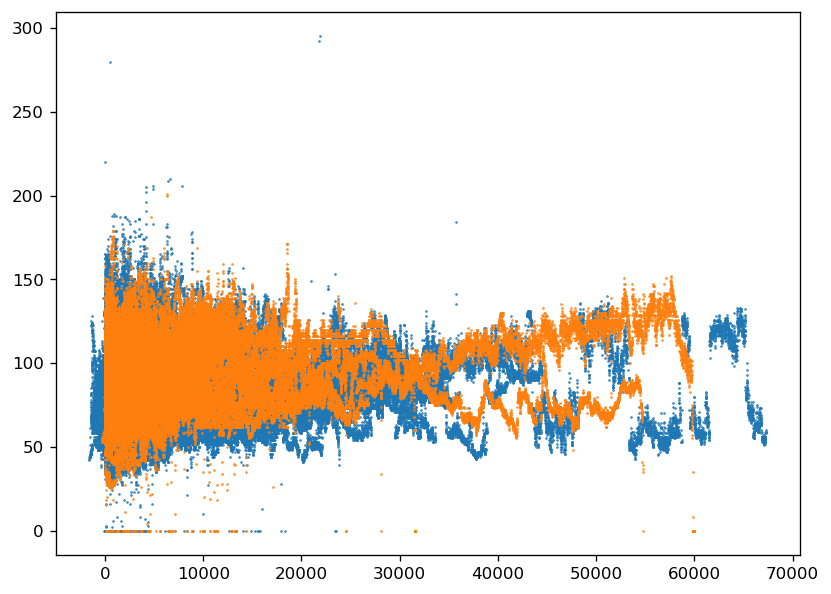

In [33]:
x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic']['heartrate']
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic']['heartrate']
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

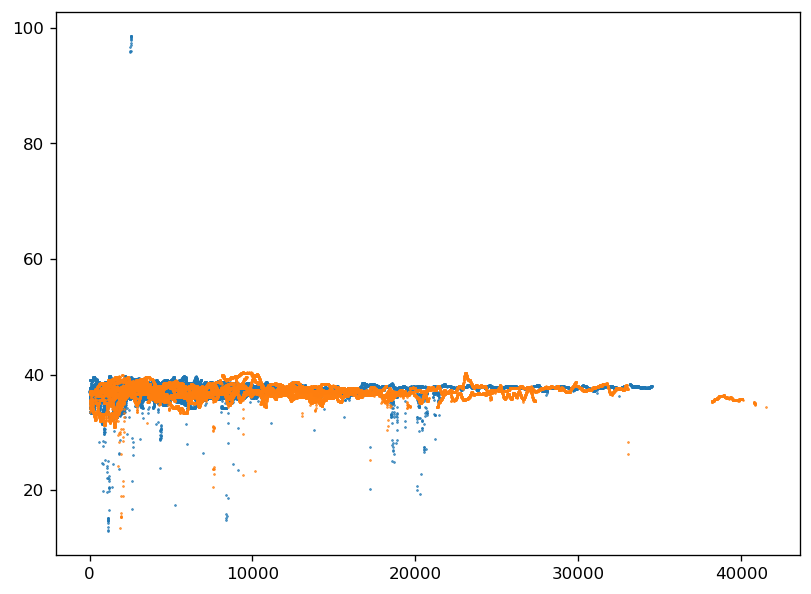

In [18]:
entry = 'temperature'
x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

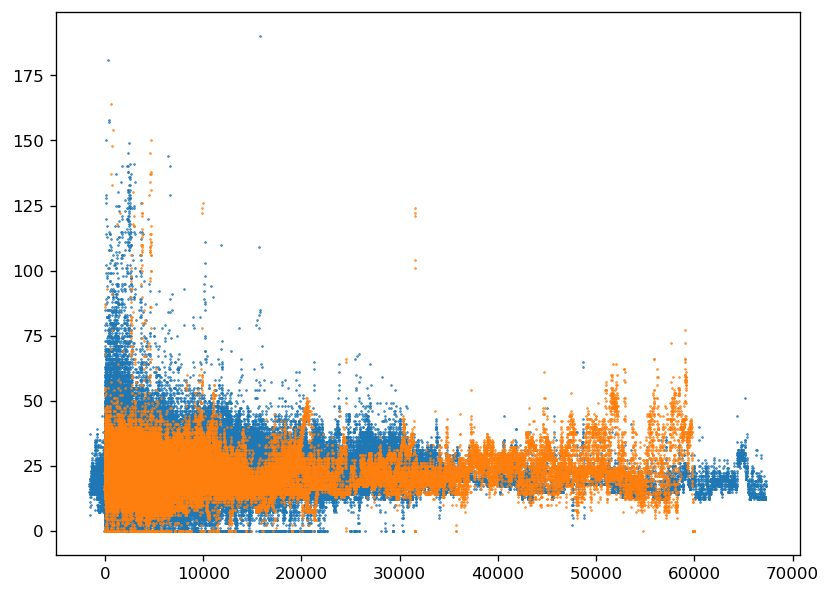

In [28]:
entry = 'respiration'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

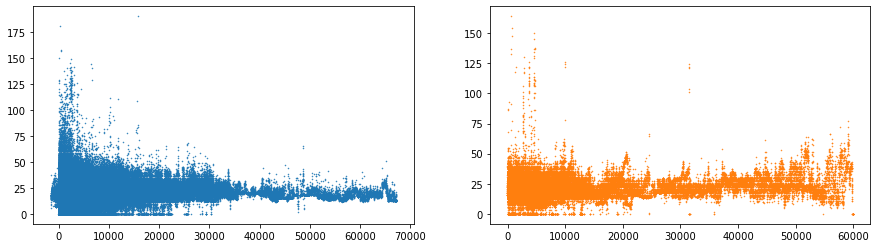

In [75]:
entry = 'respiration'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

axes[0].plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
axes[1].plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None', color='C1')

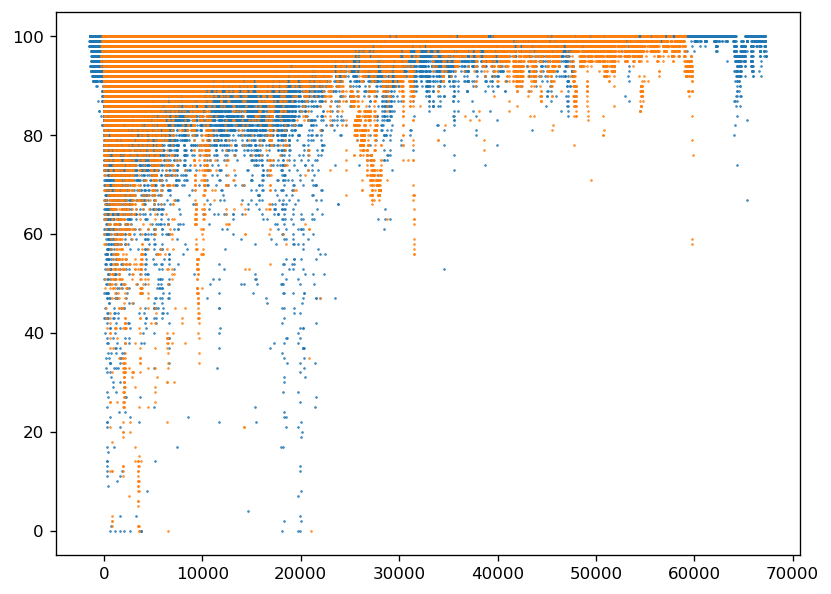

In [29]:
entry = 'sao2'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

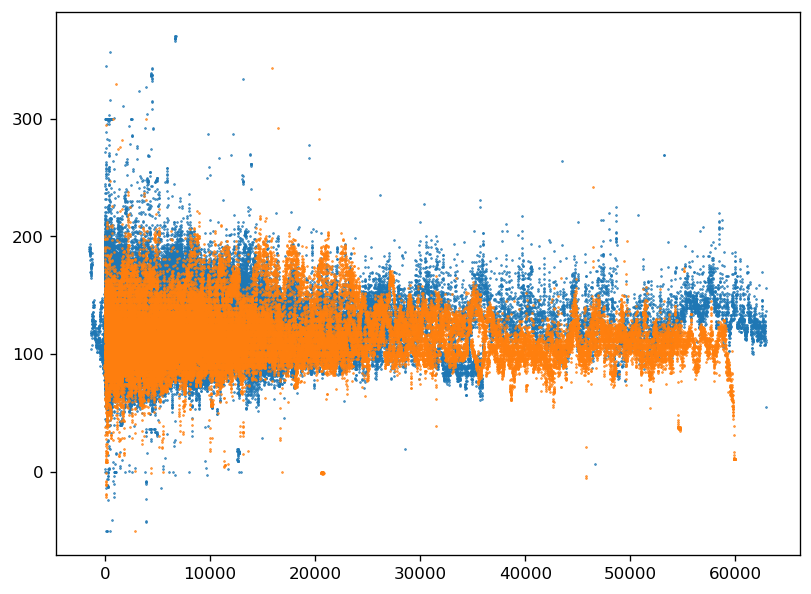

In [30]:
entry = 'systemicsystolic'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

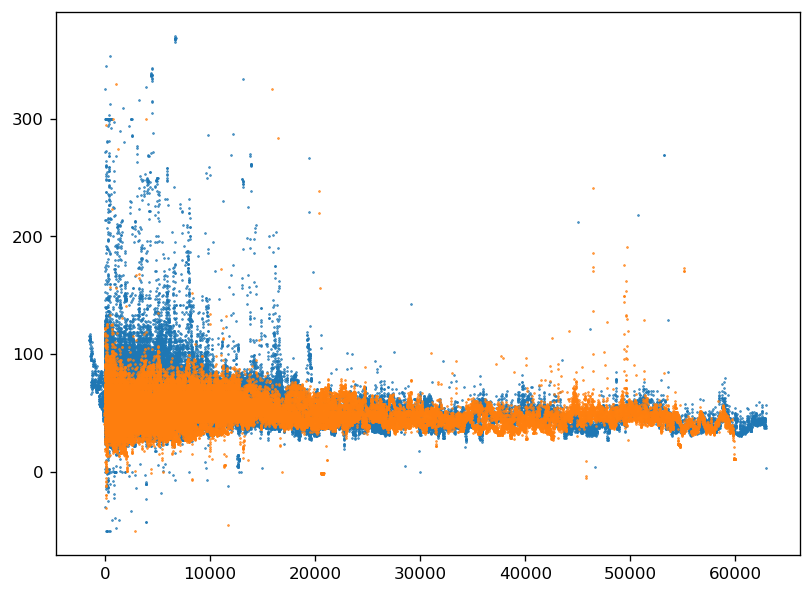

In [31]:
entry = 'systemicdiastolic'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

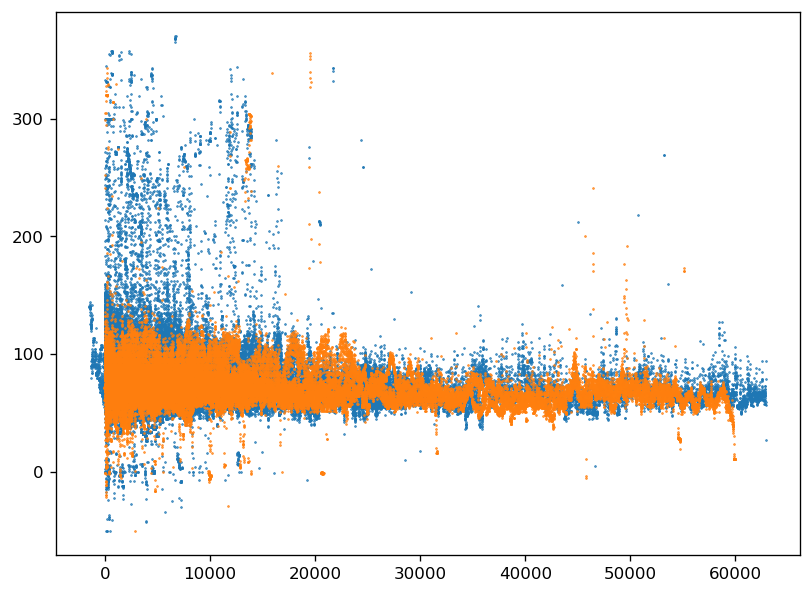

In [32]:
entry = 'systemicmean'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid]['vitalperiodic']['observationoffset']
        y_live += patient[pid]['vitalperiodic'][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid]['vitalperiodic']['observationoffset']
        y_expired += patient[pid]['vitalperiodic'][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()


ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

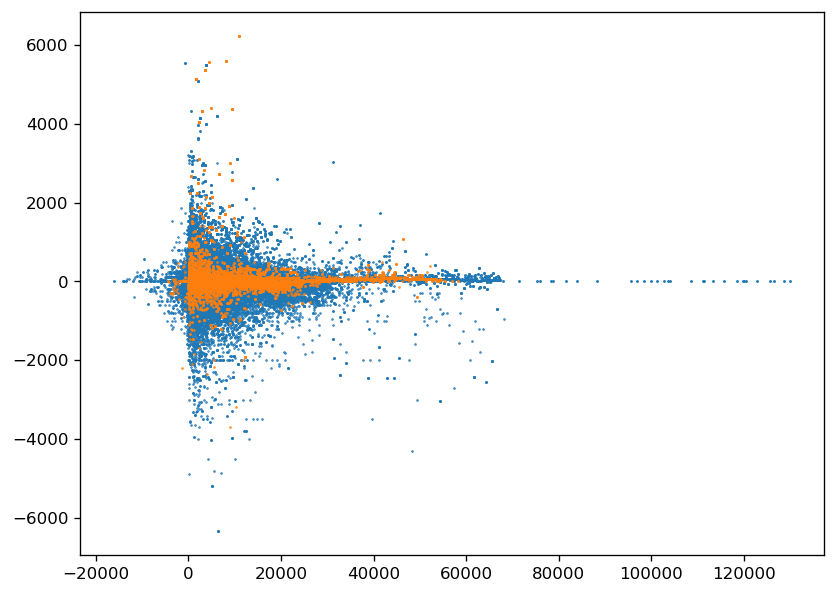

In [59]:
entry = 'nettotal'
entry_group = 'intakeoutput'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid][entry_group]['intakeoutputentryoffset']
        y_live += patient[pid][entry_group][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid][entry_group]['intakeoutputentryoffset']
        y_expired += patient[pid][entry_group][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()

x_live = np.array(x_live)
y_live = np.array(y_live)
x_live = x_live[np.logical_and(y_live>-10000, y_live<10000)]
y_live = y_live[np.logical_and(y_live>-10000, y_live<10000)]

x_expired = np.array(x_expired)
y_expired = np.array(y_expired)
ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

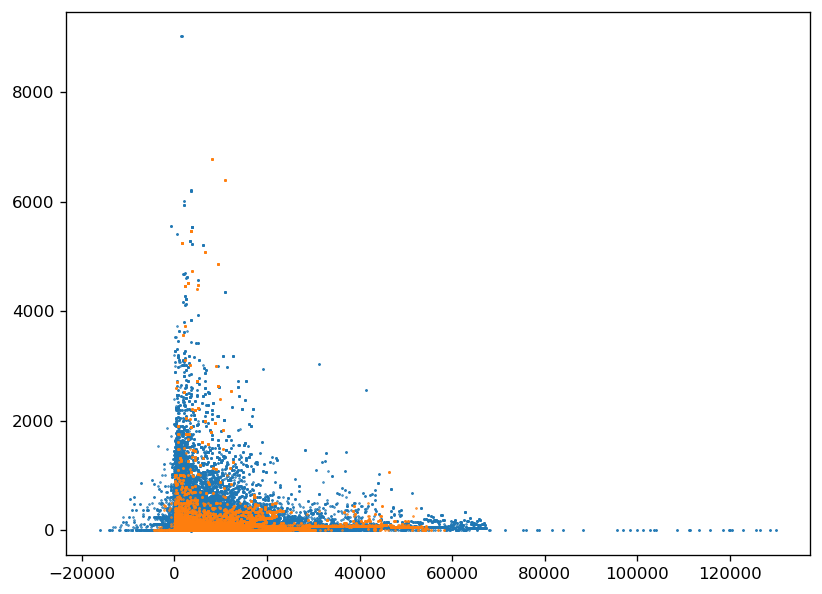

In [60]:
entry = 'intaketotal'
entry_group = 'intakeoutput'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid][entry_group]['intakeoutputentryoffset']
        y_live += patient[pid][entry_group][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid][entry_group]['intakeoutputentryoffset']
        y_expired += patient[pid][entry_group][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()

x_live = np.array(x_live)
y_live = np.array(y_live)
x_live = x_live[np.logical_and(y_live>-10000, y_live<10000)]
y_live = y_live[np.logical_and(y_live>-10000, y_live<10000)]

x_expired = np.array(x_expired)
y_expired = np.array(y_expired)
ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

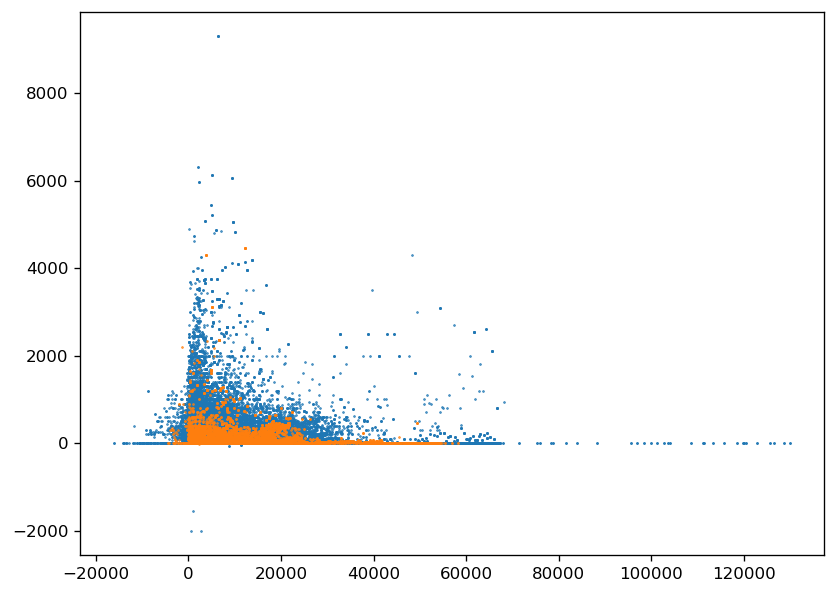

In [61]:
entry = 'outputtotal'
entry_group = 'intakeoutput'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += patient[pid][entry_group]['intakeoutputentryoffset']
        y_live += patient[pid][entry_group][entry]
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += patient[pid][entry_group]['intakeoutputentryoffset']
        y_expired += patient[pid][entry_group][entry]
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()

x_live = np.array(x_live)
y_live = np.array(y_live)
x_live = x_live[np.logical_and(y_live>-10000, y_live<10000)]
y_live = y_live[np.logical_and(y_live>-10000, y_live<10000)]

x_expired = np.array(x_expired)
y_expired = np.array(y_expired)
ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')

In [81]:
def select_entry_subset(dictionary, entry_group='intakeoutput', entry='celllabel', entry_name='Urine'):
    subset_idx = np.where(np.array(dictionary[entry_group][entry]) == entry_name)
    return subset_idx    

def select_list_subset_with_index(l, idx):
    l = np.array(l)
    return l[idx].tolist()

/home/kai/anaconda3/envs/openpose-py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



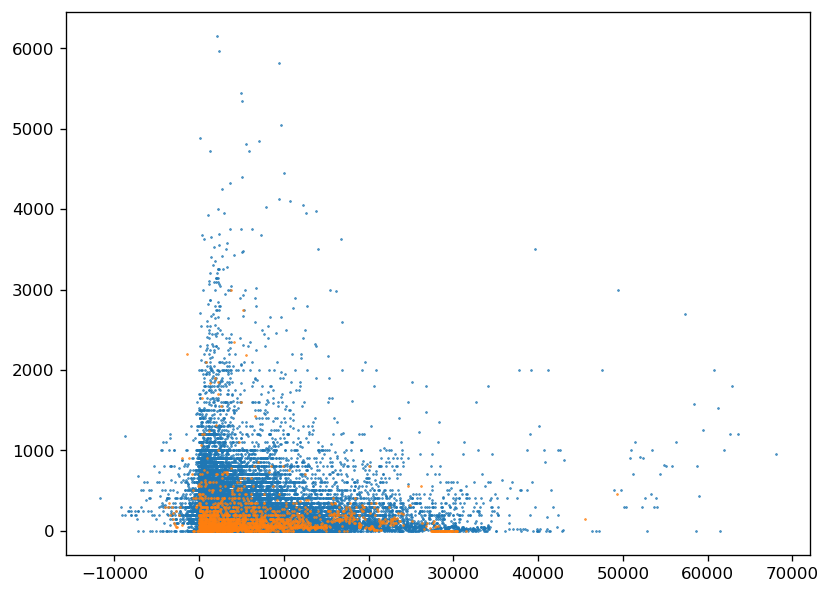

In [87]:
entry_name = 'Urine'
entry = 'celllabel'
entry_group = 'intakeoutput'

x_live = []
y_live = []
x_expired = []
y_expired = []
for pid in patient:
    subset_idx = select_entry_subset(patient[pid], entry_group, entry, entry_name)
    if patient[pid]['unitdischargestatus'] == 'Alive':
        x_live += select_list_subset_with_index(patient[pid][entry_group]['intakeoutputentryoffset'], subset_idx)
        y_live += select_list_subset_with_index(patient[pid][entry_group]['cellvaluenumeric'], subset_idx)
    elif patient[pid]['unitdischargestatus'] == 'Expired':
        x_expired += select_list_subset_with_index(patient[pid][entry_group]['intakeoutputentryoffset'], subset_idx)
        y_expired += select_list_subset_with_index(patient[pid][entry_group]['cellvaluenumeric'], subset_idx)
        
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.gca()

x_live = np.array(x_live)
y_live = np.array(y_live)
x_live = x_live[np.logical_and(y_live>-8000, y_live<8000)]
y_live = y_live[np.logical_and(y_live>-8000, y_live<8000)]

x_expired = np.array(x_expired)
y_expired = np.array(y_expired)
ax.plot(x_live, y_live, marker='.', ms=1, linestyle = 'None')
ax.plot(x_expired, y_expired, marker='.', ms=1, linestyle = 'None')